In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
plt.rcParams["font.family"] = "serif"

## Problem 1

### Subpart A
Given probability distribution:
$$
    P(y) = (1-1/5)\times y^{-1/5}
$$

we want to generate random numbers following this distribution. We first generate $x_i$'s from a uniform distribution, then we calculate $y_i$'s from the formula above. We use the *inverse transform method* to generate $y_i$'s.
\begin{align*}
    y(x) = \int_0^x(1-1/5)\times t^{-1/5}dt = x^{4/5} \\
    \implies x_i = y_i^{5/4}
\end{align*}




In [3]:
# defining the function to generate random numbers from the above distribution
def r(N):
    """
    Generates N random numbers from the distribution.
    N: number of random numbers to generate
    """
    y = np.random.uniform(0,1,N)
    return np.power(y,5/4)


Text(0, 0.5, 'p(x) (PDF)')

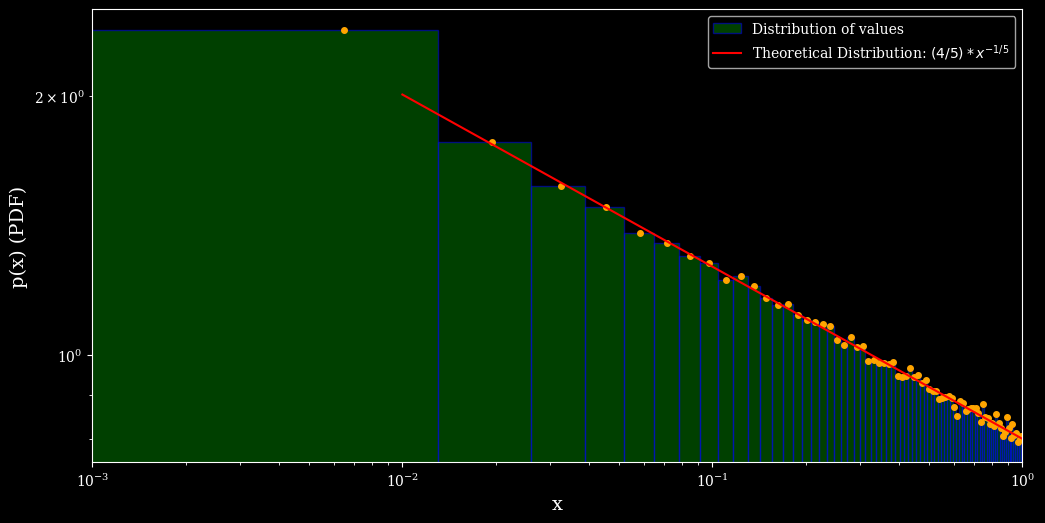

In [4]:
# generating random numbers from the above distribution

# Number of random numbers
N = 500000

# generating random numbers
y = r(N)

#plotting the distribution
fig = plt.figure(figsize=(12,6), dpi=100)
edges = np.histogram_bin_edges(y,bins='fd') # bin edges using friedman diaconis rule
# getting midpoints of the bins
bin_centers = (edges[1:] + edges[:-1])/2

vals = plt.hist(y, bins=edges, density=True, color='green',edgecolor='blue', alpha=0.5,
                 label='Distribution of values');
plt.plot(bin_centers, vals[0], 'o', ms=4, c='orange')

#plotting the distribution
x = np.linspace(1e-2,1,100);
y_dist = (4/5)*np.power(x,-1/5);
plt.plot(x,y_dist,color='red', label='Theoretical Distribution: $(4/5)*x^{-1/5}$');

plt.legend(loc='best')
plt.xlim(1e-3,1)
# converting both the axis to log scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x', fontsize=14)
plt.ylabel('p(x) (PDF)', fontsize=14)
#plt.savefig('Problem_1a.jpg', bbox_inches='tight', dpi=300)

### Subpart B
Using the above given distribution, we integrate the given function:
$$
    I = \int_{0}^1y^{-1/5}e^{-y}~dy
$$
Since we have already mapped the uniform random numbers in $(0,1)$ to the given weight function, we can use the importance sampling approach. The estimated integral will be
$$
    \hat{I} = \frac{1}{N}\sum_{i=1}^N \frac{x_i^{-1/5}e^{-x_i}}{(4/5)\times x_i^{-1/5}}
$$
where $N$ is the number of samples and
$$
    x_i = y_i^{5/4} \hspace{5ex} y_i \in Uniform(0,1)
$$


In [5]:
# defining the function to be integrated
def f(x):
    val = np.zeros(len(x))
    a = x[np.where(x<=1)[0]]
    # getting non-zero values
    val_nz = np.exp(-a)*np.power(a,-1/5)
    val[np.where(x<=1)[0]] = val_nz
    return val

# defining the weight function
def w(x):
    return (4/5)*np.power(x,-1/5)

# integrating by imporatance sampling
def imp_sampling(f,w,r,N):
    """
    Paramters
    ========================
    f: function to be integrated
    w: weigth function
    r: random variable generator
    N: Number of points
    """
    y_i = r(N)
    y = f(y_i)
    w_x = w(y_i)

    # estimator of integral
    I = np.sum(y/w_x)/N

    # calulating variance from the estimator
    F = y/w_x
    var = np.sum(F**2)/N - I**2
    return np.array([I,var])

In [6]:
# calulating the integral using the imporance sampling
# Number of points 
N = 100000

# number of iteration
M = 1000

# array to store the value of integral
I_arr = np.zeros(M)

# array to store the value of variance
var_arr = np.zeros(M)

# running the integral M times
for i in tqdm(range(M),'Iterations'):
    I,var = imp_sampling(f,w,r,N)
    I_arr[i] = I
    var_arr[i] = var

print("Approximated value of integral upto 3 decimal places: ", round(np.mean(I_arr),3))
print("True value of integral:", 0.836581)

Iterations: 100%|██████████| 1000/1000 [00:17<00:00, 55.66it/s]

Approximated value of integral upto 3 decimal places:  0.837
True value of integral: 0.836581


## Problem 2
The system of equations for the given hamiltonian are:
\begin{align*}
    \frac{dx}{dt} &= p_x \hspace{7ex} \frac{dp_x}{dt} &= -x -2xy\\
    \frac{dy}{dt} &= p_y \hspace{7ex} \frac{dp_y}{dt} &= y^2 -y
     -x^2
\end{align*}

In [128]:
# defining the function to calculate the derivatives
def derivs(q,t):
    """
    Returns the derivatives of velocities.
    d(p_x)/dt = -x - 2xy
    d(p_y)/dt = y^2 -x -x^2
    
    Parameters:
    ========================
    q: Current value in format [x, y]
    t: time
    """

    x,y = q
    v1 = -x - (2*x*y) # d(p_x)/dt
    v2 = (y**2) -y -(x**2) # d(p_y)/dt

    return np.array([v1,v2])

# leap frog method with velocity verlet
def leap_frog(q, derivs,t,h):
    """
    Returns the next value of q using the leap frog method.
    
    Parameters:
    ========================
    q: Current value in format [x, y, p_x, p_y]
    derivs: function to calculate the derivatives
    t: time
    h: step size
    """
    
    # velocity half step
    p_half = q[2:] + 0.5*h*derivs(q[0:2],t)
    # position full step    
    q_full = q[0:2] + h*p_half
    # velocity full step
    p_full = p_half + 0.5*h*derivs(q_full,t+h)


    # returning the next value of q
    return np.concatenate((q_full,p_full))

# defining the energy function
def energy(q):
    """
    Returns the energy of the system. In this case it is the hamiltonina
    E = 1/2*(v_x^2 + v_y^2) + 1/2*(x^2 + y^2) + x^2y - (1/3)y^3
    
    Parameters:
    ========================
    q: Current value in format [x, y, v_x, v_y]
    """
    x,y,p_x,p_y = q
    
    T1 = 0.5*(p_x**2 + p_y**2)
    T2 = 0.5*(x**2 + y**2)
    T3 = (x**2)*y
    T4 = -(1/3)*(y**3)
    return T1 + T2 + T3 + T4

In [176]:
# initializing values
q0 = np.array([0.2, 0.2, 0.1, 0.1]) # initial values of [x, y, p_x, p_y]

# time array
t_start = 0
t_end   = 10
N = 10000 #number of time stamps
h = (t_end - t_start)/N
t = np.linspace(t_start, t_end, N+1)

# array for storing the values
E = np.zeros(N+1)
q = np.zeros((N+1,4))
q[0] = q0
E[0] = energy(q0)

# updating the values using leap frog method
q_current = q0
for i in tqdm(range(N),'Iterations'):
    q_next = leap_frog(q_current, derivs, t[i], h)
    E[i+1] = energy(q_next) #storring the energy
    # storing the values
    q[i+1] = q_next
    # updating the values
    q_current = q_next


Iterations: 100%|██████████| 10000/10000 [00:00<00:00, 43327.80it/s]


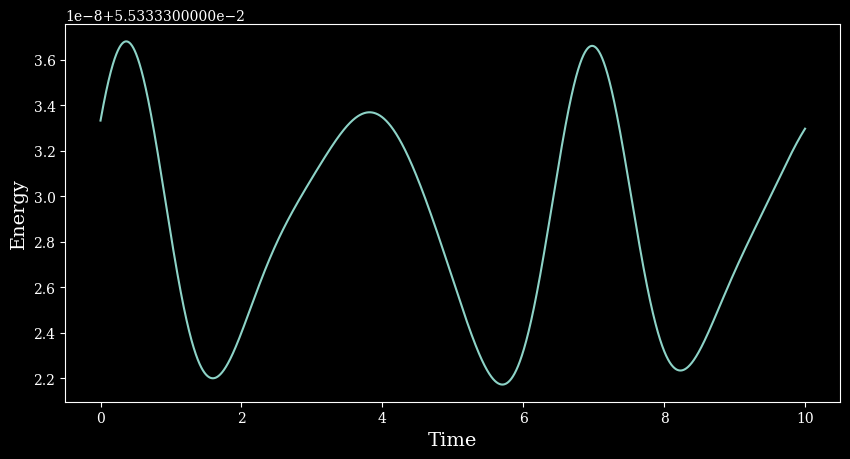

In [177]:
#plotting energy variation with time

plt.figure(figsize=(10,5), dpi=100)
plt.plot(t,E)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Energy', fontsize=14)

plt.savefig('Problem_2.jpg', bbox_inches='tight', dpi=300)

In [178]:
print("Approximated value of energy upto 3 decimal places: ", round(np.mean(E),3))

Approximated value of energy upto 3 decimal places:  0.055
